#### !!!! DO NOT RUN THIS FIRST CELL UNLESS YOU HAVE THE SAME VENV PATH ISSUE THAT I DO

In [1]:
import sys
sys.path.append('/Users/tunadorable/local-repos/ng-video-lecture/venv/lib/python3.11/site-packages')

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import time
from typing import List

#### !!!! ONLY FOR APPLE SILICON


In [3]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

In [25]:
# hyperparameters
b = 4 # how many independent sequences will we process in parallel?
t = 16 # what is the maximum context length for predictions?
max_iters = 1000
eval_interval = 50
lr = 3e-4 # learning rate for each backprop step
eval_iters = 20
d = 32 # embedding aka hidden dimension
h = 4 # number of attention heads
l = 4 # number of transormer layers
dropout = 0.2 # % of parameters to ignore every iteration
l2 = 0.01 # multiplier for our L2 norm to encourage sparsity

nesting_list = [4,8,16,32]

In [5]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [6]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
v = len(chars)
print(chars, v)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 65


In [7]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

In [8]:
# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [9]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - t, (b,))
    x = torch.stack([data[i:i+t] for i in ix])
    y = torch.stack([data[i+1:i+t+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [10]:
# so you can see what the tokenized data looks like
x,y = get_batch('train')
print("x ", x.shape, "\n", x)
print("y ", y.shape, "\n", y)

x  torch.Size([4, 16]) 
 tensor([[60, 43, 57,  1, 44, 39, 50, 50,  6,  1, 58, 46, 43,  1, 61, 47],
        [59, 56,  1, 47, 52, 57, 59, 44, 44, 47, 41, 47, 43, 52, 41, 43],
        [59, 45, 46, 58, 43, 56,  0, 20, 47, 57,  1, 58, 43, 39, 56, 57],
        [ 1, 51, 53, 59, 52, 58, 39, 47, 52,  1, 58, 53, 54, 57,  8,  0]],
       device='mps:0')
y  torch.Size([4, 16]) 
 tensor([[43, 57,  1, 44, 39, 50, 50,  6,  1, 58, 46, 43,  1, 61, 47, 52],
        [56,  1, 47, 52, 57, 59, 44, 44, 47, 41, 47, 43, 52, 41, 43,  6],
        [45, 46, 58, 43, 56,  0, 20, 47, 57,  1, 58, 43, 39, 56, 57,  1],
        [51, 53, 59, 52, 58, 39, 47, 52,  1, 58, 53, 54, 57,  8,  0, 21]],
       device='mps:0')


In [11]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval() # sets model to eval mode
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train() # just resets to training mode
    return out


######## NEEDS TO BE CHANGED TO CHECK MATRYOSHA LOSS

In [12]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 4 * d),
            nn.ReLU(),
            nn.Linear(4 * d, d),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [13]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(d, head_size, bias=False)
        self.query = nn.Linear(d, head_size, bias=False)
        self.value = nn.Linear(d, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(t, t))) # mask future timestesps
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        b,t,d = x.shape
        k = self.key(x)   # (b,t,d/h)
        q = self.query(x) # (b,t,d/h)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (b, t, d/h) @ (b, d/h, t) -> (b, t, t)
        wei = wei.masked_fill(self.tril[:t, :t] == 0, float('-inf')) # (b, t, t)
        wei = F.softmax(wei, dim=-1) # (b, t, t)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (b,t,d/h)
        out = wei @ v # (b, t, t) @ (b, t, d/h) -> (b, t, d/h)
        return out

In [14]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, h, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(h)])
        self.proj = nn.Linear(head_size * h, d)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [15]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, d, h):
        # d: embedding dimension, h: the number of heads we'd like
        super().__init__()
        head_size = d // h # the double backslash just makes the output an int instead of float
        self.sa = MultiHeadAttention(h, head_size)
        self.ffwd = FeedFoward(d)
        self.ln1 = nn.LayerNorm(d)
        self.ln2 = nn.LayerNorm(d)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [16]:
class Matryoshka_CE_Loss(nn.Module):
    '''
    Loss function for Matryoshka Representation Learning 
    '''
    def __init__(self, relative_importance: List[float]=None, **kwargs):
        super(Matryoshka_CE_Loss, self).__init__()
        self.criterion = nn.CrossEntropyLoss(**kwargs)
        
        # relative importance shape: [G]
        # this is optional for if you want to weight them differently
        self.relative_importance = relative_importance

    def forward(self, logits, target):
        # logits shape: [g granularities, b batch size, t sequence length, v number of classes]
        # EXCEPT IT COMES IN THE FORM OF A TUPLE OF TENSORS SO REALLY
        g = len(logits)
        b,t,v = logits[-1].shape
        # target shape: [b batch size, t sequence length]

        # Calculate losses for each output and stack them
        # might need to do .view() or .reshape() to make sure these go in well
        losses = torch.stack([self.criterion(logits_i.view(b*t, v), target.view(b*t)) for logits_i in logits])

        # Set relative_importance to 1 if not specified
        # I don't think i'm gonna be emssing around with this part
        rel_importance = torch.ones_like(losses) if self.relative_importance is None else torch.tensor(self.relative_importance)

        # Apply relative importance weights
        weighted_losses = rel_importance * losses
        return weighted_losses.sum()

In [ ]:
### old
class MRL_Linear_Layer(nn.Module):
	def __init__(self, nesting_list: List, num_classes=v, efficient=False, **kwargs):
		super(MRL_Linear_Layer, self).__init__()
		self.nesting_list = nesting_list
		self.num_classes = num_classes # Number of classes for classification
		self.efficient = efficient
		if self.efficient:
            # i did not know you could set & get attributes like this, i should prolly learn python lmao
            # I would like to change this to instead use the model's embedding matrix self.token_embedding_table
			setattr(self, f"nesting_classifier_{0}", nn.Linear(nesting_list[-1], self.num_classes, **kwargs))		
		else:
			for i, num_feat in enumerate(self.nesting_list):
				setattr(self, f"nesting_classifier_{i}", nn.Linear(num_feat, self.num_classes, **kwargs))	

	def reset_parameters(self):
		if self.efficient:
			self.nesting_classifier_0.reset_parameters()
		else:
			for i in range(len(self.nesting_list)):
				getattr(self, f"nesting_classifier_{i}").reset_parameters()


	def forward(self, x):
        # so this is ouptutting a tuple of tensors. might have to stack them later idk
		nesting_logits = ()
		for i, num_feat in enumerate(self.nesting_list):
			if self.efficient:
                # not really sure where we ever even had the option to remove bias
                # when i switch to embedding matrix i'll have to use the `is None` option
				if self.nesting_classifier_0.bias is None:
					nesting_logits += (torch.matmul(x[..., :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()), )
				else:
					nesting_logits += (torch.matmul(x[..., :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()) + self.nesting_classifier_0.bias, )
			else:
				nesting_logits +=  (getattr(self, f"nesting_classifier_{i}")(x[..., :num_feat]),)

		return nesting_logits 

In [133]:
# absolutely no clue why i included so many options when i only intend to test efficient=True and passing the embedding matrix in

class MRL_Linear_Layer(nn.Module):
    def __init__(self, nesting_list: List, num_classes=v, efficient=False, passed_in_layer=None, **kwargs):
        super(MRL_Linear_Layer, self).__init__()
        self.nesting_list = nesting_list
        self.num_classes = num_classes  # Number of classes for classification
        self.efficient = efficient
        
        # efficient means we'll be using only one matrix and subsetting it to make our separate heads
        if self.efficient:
            # we can pass in a size (v,d) layer (such as the embedding matrix)
            if passed_in_layer is None:
                self.nesting_classifier_0 = nn.Linear(nesting_list[-1], self.num_classes, bias=False, device=device, **kwargs)	
            else:
                # Use the passed-in layer (embedding matrix) of shape (d,v) directly instead of creating a new learnable layer
                self.nesting_classifier_0 = passed_in_layer.to(device)
        else:
            # if we've not chosen efficient & are not passing an embedding matrix in, by default we'll construct a separate
            # linear head of the correct size for each dimension size of interest
            for i, num_feat in enumerate(self.nesting_list):
                setattr(self, f"nesting_classifier_{i}", nn.Linear(num_feat, self.num_classes, bias=False, device=device, **kwargs))

    def forward(self, x):
        nesting_logits = ()
        for i, num_feat in enumerate(self.nesting_list):
            if self.efficient:
                nesting_logits += (torch.matmul(x[..., :num_feat], self.nesting_classifier_0[:num_feat,:]), )
            else:
                nesting_logits += (getattr(self, f"nesting_classifier_{i}")(x[..., :num_feat]),)
        
        return nesting_logits

In [134]:
class matryoshkaGPT(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(v, d).to(device)
        
        # simple learned positional encodings rather than sine or RoPE
        self.position_embedding_table = nn.Embedding(t, d) 
        self.blocks = nn.Sequential(*[Block(d, h) for _ in range(l)]) # bulk of the beast
        self.ln_f = nn.LayerNorm(d) # final layer norm

        ### A REGULAR GPT's OUTPUT HEAD
        # output classifier
        #self.lm_head = nn.Linear(d, v)
        # Alternatively, use the embedding matrix transpose for the output layer, 
        # which is a common technique for interpretability and parameter reduction.
        # self.lm_head = self.token_embedding_table.weight.t()  

        ### MATRYOSHKA OUTPUT HEAD(S)
        self.m_head = MRL_Linear_Layer(nesting_list=nesting_list, efficient=True, passed_in_layer=self.token_embedding_table.weight.t())
        ### MATRYOSHKA LOSS
        self.m_loss = Matryoshka_CE_Loss()
        
        # initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        b, t = idx.shape
        
        # idx and targets are both (b,t) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (b,t,d)
        pos_emb = self.position_embedding_table(torch.arange(t, device=device)) # (t,d)
        x = tok_emb + pos_emb # (b,t,d) + (t,d) = (b,t,d)
        x = self.blocks(x) # (b,t,d) -> (b,t,d)
        x = self.ln_f(x) # (b,t,d) -> (b,t,d)
        
        #logits = self.lm_head(x)
        logits = self.m_head(x) # tensor [b,t,d] -> tuple ([b,t,d_0], [b,t,d_1], [b,t,d_2],..., [b,t,d_g])
        
        if targets is None:
            loss = None
        else:
            #b, t, v = logits.shape
            #loss = F.cross_entropy(logits.view(b*t, v), targets.view(b*t))

            loss = self.m_loss(logits, targets) # (g,b,t,d) & (b,t) -> 

        return logits, loss

    def generate(self, idx, max_new_tokens, degree=len(nesting_list)-1):
        assert degree >= 0 & degree < len(nesting_list)
        # idx is (b, t) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -t:]
            # get the predictions
            logits, loss = self(idx_cond)
            # select the desired degree
            logits = logits[degree]
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (b, d)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (b, d)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (b, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (b, t+1)
        return idx

In [135]:
model = matryoshkaGPT().to(device)
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=l2)
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e3, 'K parameters')

53.088 K parameters


In [162]:
start_time = time.time()
for iter in range(max_iters):

    # sample a batch of data
    xb, yb = get_batch('train')
    
    # train
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        current_time = time.time()
        elapsed_time = current_time - start_time
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, time elapsed: {elapsed_time:.2f} seconds")

step 0: train loss 10.5921, val loss 10.5341, time elapsed: 0.23 seconds
step 50: train loss 10.6199, val loss 10.7946, time elapsed: 7.92 seconds
step 100: train loss 10.4400, val loss 10.4084, time elapsed: 15.20 seconds
step 150: train loss 10.5047, val loss 10.5418, time elapsed: 22.17 seconds
step 200: train loss 10.4453, val loss 10.6992, time elapsed: 29.11 seconds
step 250: train loss 10.3649, val loss 10.5758, time elapsed: 36.02 seconds
step 300: train loss 10.5609, val loss 10.4141, time elapsed: 42.92 seconds
step 350: train loss 10.6369, val loss 10.3596, time elapsed: 49.83 seconds
step 400: train loss 10.3933, val loss 10.3923, time elapsed: 56.76 seconds
step 450: train loss 10.3888, val loss 10.2339, time elapsed: 63.71 seconds
step 500: train loss 10.4311, val loss 10.3269, time elapsed: 70.64 seconds
step 550: train loss 10.4352, val loss 10.4411, time elapsed: 77.58 seconds
step 600: train loss 10.6120, val loss 10.2667, time elapsed: 84.50 seconds
step 650: train l

## save the trained model


In [22]:
torch.save(model.state_dict(), f'models/{model.__class__.__name__}_b{b}_t{t}_d{d}_h{h}_l{l}_lr{lr}_drop{dropout}_l2-{l2}_nestinglist{nesting_list}_{time.strftime("%Y-%m-%d|%H-%M-%S")}.pth')

RuntimeError: Parent directory models does not exist.

# Load a saved model

In [ ]:
model = GPT().to(device)  # Initialize a model with the same architecture

# Load the saved state dictionary
model.load_state_dict(torch.load('models/GPT_b24_t128_d128_h8_l8_lr0.0003_drop0.2_l2-0.01_2024-01-25|23-31-12.pth'))

# If you plan to continue training the model, switch to training mode
#model.train()

# If you only plan to do inference, switch to evaluation mode
model.eval()

## Inference

In [163]:
%%time
input_str = "JULIET:\nO Romeo, Romeo! wherefore art thou R" # the classic line
context_tensor = torch.tensor([encode(input_str)], dtype=torch.long, device=device)
output = model.generate(context_tensor, max_new_tokens=250, degree = 0)
output_str = decode(output[0].tolist())
print(output_str)

JULIET:
O Romeo, Romeo! wherefore art thou Ry raud play
ee are !
.wel. ITAMLd .

Njalid have nhlle melte m it;
Raueabul h
S nurafiseerCf
Laar lcl;
a ha'-BHeot by aniee urmy wer
MWameccol akeoCh tolir!

Lhannos
WTTiby iaoth  LAd fffl then att t hy auuar pen rouat oo'eu -
A3ld,et
.
eeossu3geaary
CPU times: user 7.37 s, sys: 290 ms, total: 7.66 s
Wall time: 7.68 s


In [164]:
%%time
input_str = "JULIET:\nO Romeo, Romeo! wherefore art thou R" # the classic line
context_tensor = torch.tensor([encode(input_str)], dtype=torch.long, device=device)
output = model.generate(context_tensor, max_new_tokens=250, degree = 3)
output_str = decode(output[0].tolist())
print(output_str)

JULIET:
O Romeo, Romeo! wherefore art thou RouJURTF

A, ssuir moy
De burid, Uk wey oanefd, dudusscuy or lodt ano to qur te thosere us,
Anule mr trlsons be rase r thrord incy mert,

Tottnoumar?

RIUSourcerd wenvets bo coutoos!
U

RTYi moigmy lanlacek,pe Hett o tkigeu thad I avee th.


Kabnorois
CPU times: user 7.23 s, sys: 239 ms, total: 7.47 s
Wall time: 7.48 s


# analyzing token & concept embedding vectors

In [165]:
# Access the embedding weight matrix
embedding_matrix = model.token_embedding_table.weight.data

# If you want to look at the embedding for a specific token index, say index 42
token = 'a'
token_index = stoi[token]
token_embedding = embedding_matrix[token_index]

print(f"Embedding for token '{token}' index {token_index}: {token_embedding}")

Embedding for token 'a' index 39: tensor([ 0.2541,  0.0158,  0.1195, -0.1126, -0.1444,  0.0804,  0.0302,  0.2103,
        -0.1045, -0.1187,  0.0098,  0.0364, -0.0006, -0.2195,  0.0235, -0.0967,
        -0.0042, -0.0701, -0.0869,  0.0529, -0.1798,  0.0173, -0.0993,  0.1281,
        -0.0270,  0.0352,  0.0574,  0.0266, -0.0937,  0.0655,  0.0251, -0.0635],
       device='mps:0')


In [174]:
def cosine_similarity(embedding1, embedding2):
    # Calculate the cosine similarity between two embeddings
    return F.cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0))

# Example tokens
token1 = 'a'
token2 = 'b'
token3 = 'i'
token4 = 'A'
token5 = '.'

# Convert tokens to indices
index1 = stoi[token1]
index2 = stoi[token2]
index3 = stoi[token3]
index4 = stoi[token4]
index5 = stoi[token5]

# Retrieve embeddings from the model
embedding1 = model.token_embedding_table.weight[index1]
embedding2 = model.token_embedding_table.weight[index2]
embedding3 = model.token_embedding_table.weight[index3]
embedding4 = model.token_embedding_table.weight[index4]
embedding5 = model.token_embedding_table.weight[index5]

# Calculate cosine similarity
for i, degree in enumerate(nesting_list):
    similarity = cosine_similarity(embedding1[:degree], embedding2[:degree])
    print(f"degree {degree} Cosine similarity between '{token1}' and '{token2}':", similarity.item())
for i, degree in enumerate(nesting_list):
    similarity = cosine_similarity(embedding1[:degree], embedding3[:degree])
    print(f"degree {degree} Cosine similarity between '{token1}' and '{token3}':", similarity.item())
for i, degree in enumerate(nesting_list):
    similarity = cosine_similarity(embedding1[:degree], embedding4[:degree])
    print(f"degree {degree} Cosine similarity between '{token1}' and '{token4}':", similarity.item())
for i, degree in enumerate(nesting_list):
    similarity = cosine_similarity(embedding1[:degree], embedding5[:degree])
    print(f"degree {degree} Cosine similarity between '{token1}' and '{token5}':", similarity.item())

degree 4 Cosine similarity between 'a' and 'b': -0.27076229453086853
degree 8 Cosine similarity between 'a' and 'b': -0.03153485059738159
degree 16 Cosine similarity between 'a' and 'b': 0.1147657185792923
degree 32 Cosine similarity between 'a' and 'b': 0.15055745840072632
degree 4 Cosine similarity between 'a' and 'i': 0.9638397097587585
degree 8 Cosine similarity between 'a' and 'i': 0.9492855072021484
degree 16 Cosine similarity between 'a' and 'i': 0.9213238954544067
degree 32 Cosine similarity between 'a' and 'i': 0.8798273801803589
degree 4 Cosine similarity between 'a' and 'A': -0.5384604334831238
degree 8 Cosine similarity between 'a' and 'A': -0.31264764070510864
degree 16 Cosine similarity between 'a' and 'A': -0.295528769493103
degree 32 Cosine similarity between 'a' and 'A': -0.16652444005012512
degree 4 Cosine similarity between 'a' and '.': -0.5381404161453247
degree 8 Cosine similarity between 'a' and '.': -0.4922112226486206
degree 16 Cosine similarity between 'a' and 

In [168]:
def plot_token_similarity(tokens, model, stoi, degree, nesting_list=nesting_list):
    # Initialize a matrix to store cosine similarities
    similarity_matrix = np.zeros((len(tokens), len(tokens)))

    degree = nesting_list[degree]
    
    # Calculate cosine similarity for each pair of tokens
    for i, token1 in enumerate(tokens):
        for j, token2 in enumerate(tokens):
            index1 = stoi[token1]
            index2 = stoi[token2]
            embedding1 = model.token_embedding_table.weight[index1]
            embedding2 = model.token_embedding_table.weight[index2]
            similarity = F.cosine_similarity(embedding1[:degree].unsqueeze(0), embedding2[:degree].unsqueeze(0))
            similarity_matrix[i, j] = similarity.item()
    
    # Plotting
    fig, ax = plt.subplots(figsize=(14, 14))
    cax = ax.matshow(similarity_matrix, cmap='viridis', vmin=-1, vmax=1)
    fig.colorbar(cax)

    # Set axis labels to the tokens
    ax.set_xticks(np.arange(len(tokens)))
    ax.set_yticks(np.arange(len(tokens)))
    ax.set_xticklabels(tokens)
    ax.set_yticklabels(tokens)

    # Label axes
    ax.set_xlabel('Tokens')
    ax.set_ylabel('Tokens')
    ax.set_title(f'Cosine Similarity Between Token Embeddings of degree {degree}')

    # Show the plot
    plt.show()

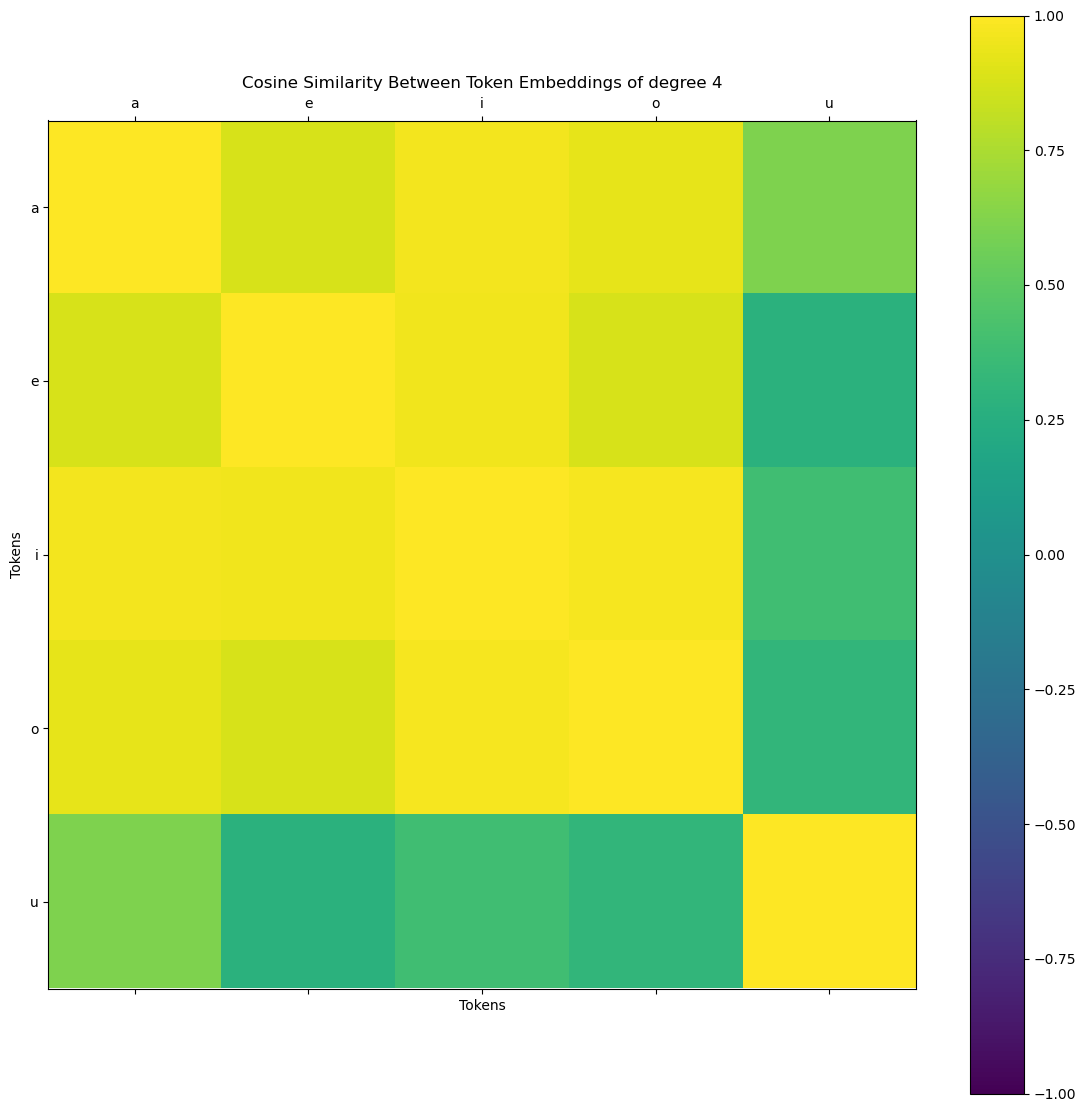

In [169]:
# Example usage with vowels
vowels = ['a', 'e', 'i', 'o', 'u']
plot_token_similarity(vowels, model, stoi, degree=0)

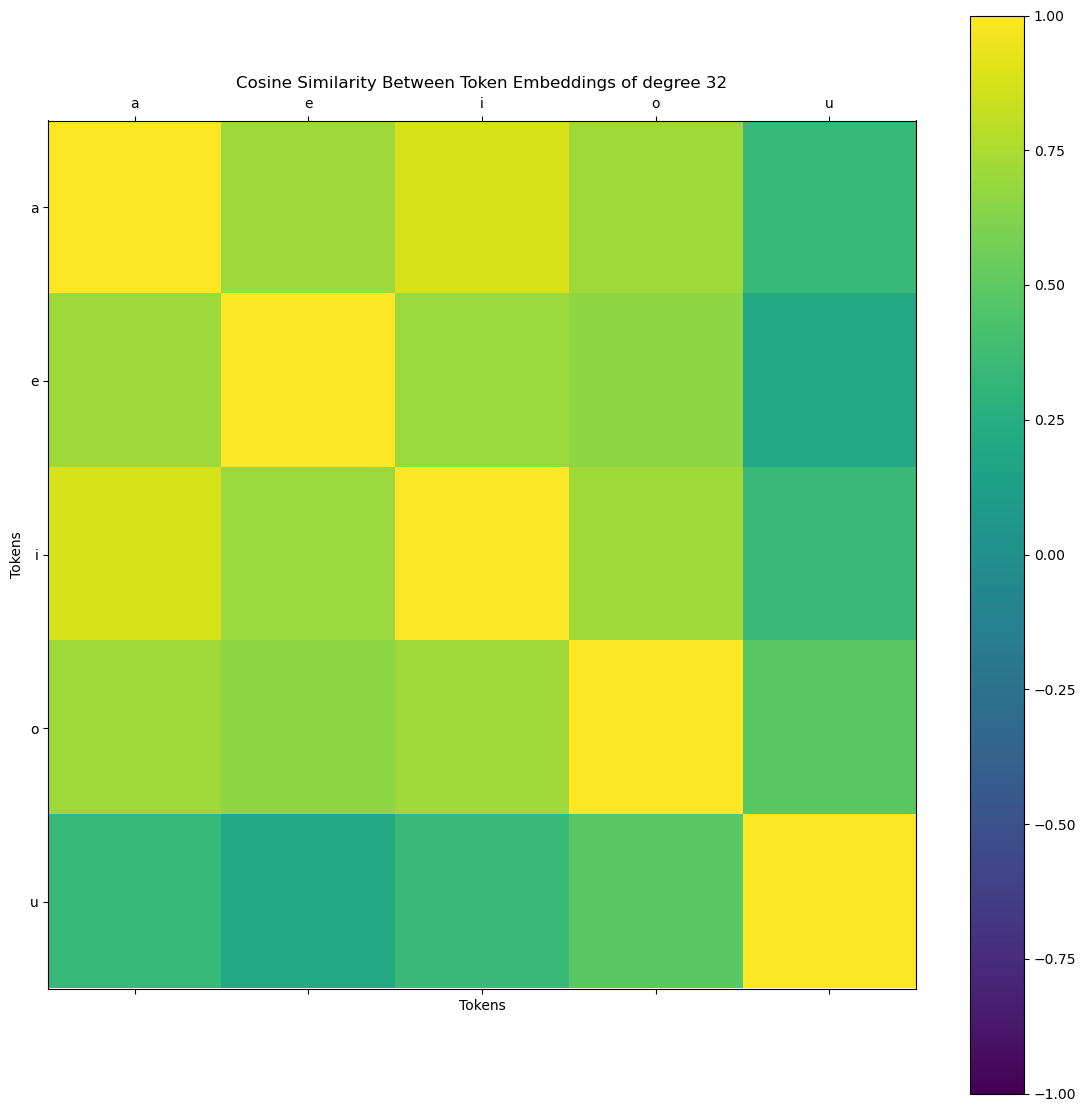

In [170]:
plot_token_similarity(vowels, model, stoi, degree=3)

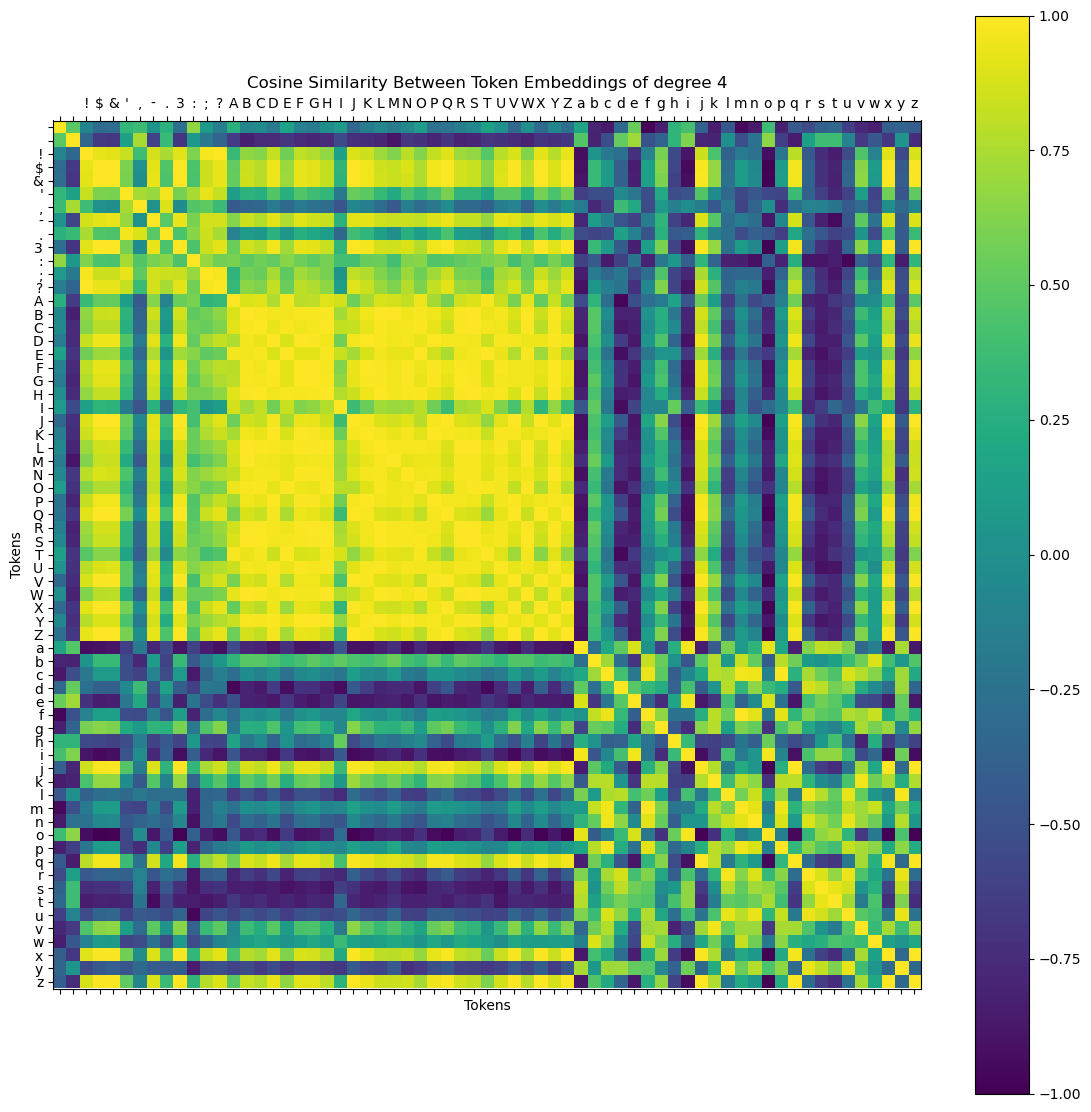

In [171]:
plot_token_similarity(chars, model, stoi, degree=0)

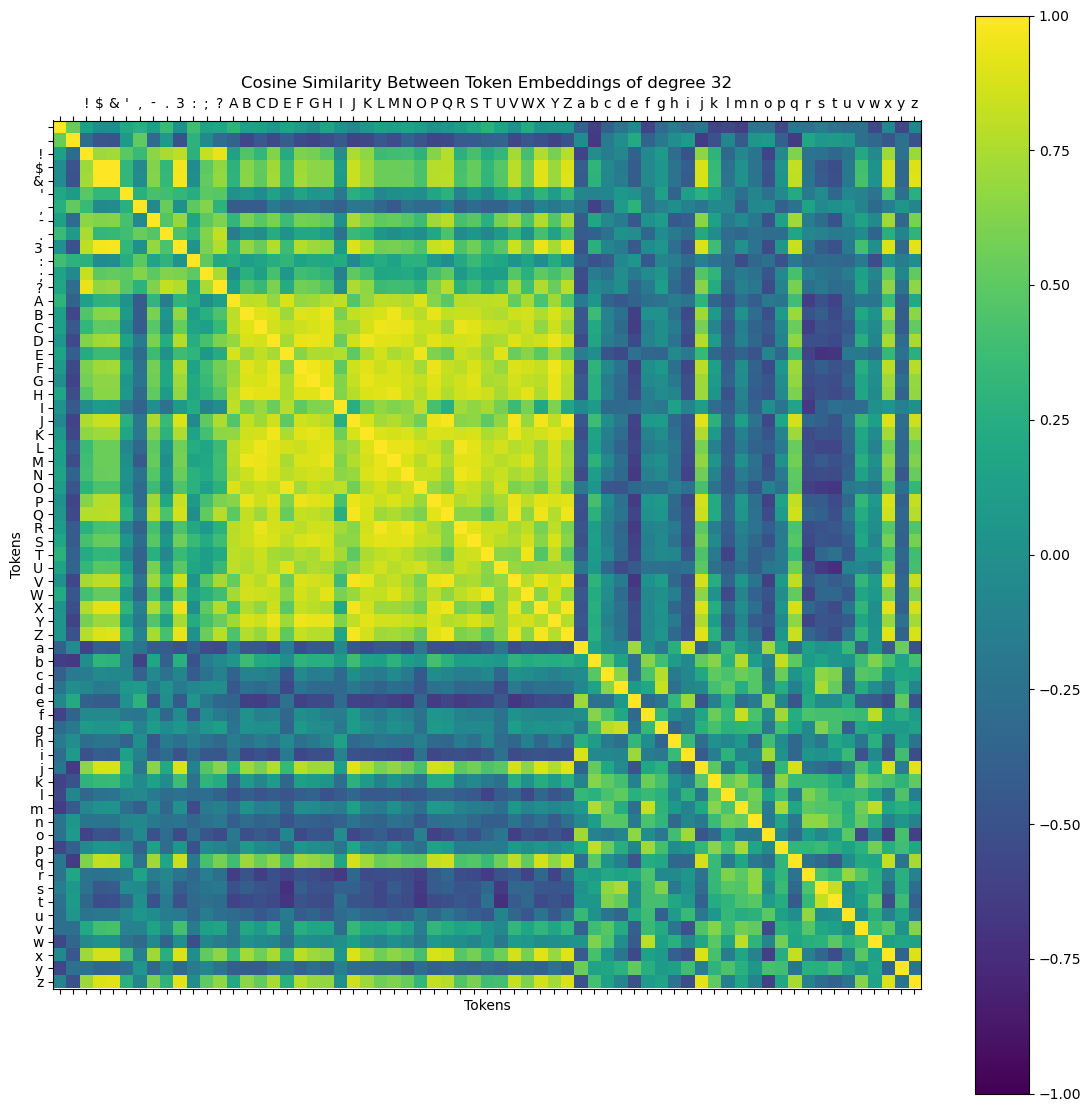

In [172]:
plot_token_similarity(chars, model, stoi, degree=3)

# Thinking about how layernorm affects these hierarchical vectors

In [176]:
### gotta turn this into a way to keep each sub-vector on the unit hypersphere

import numpy as np
from scipy.stats import shapiro

def adjust_and_concatenate(v1, v2):
    """
    Concatenates two vectors and adjusts the second vector so that the entire concatenated vector
    is normally distributed with a mean of 0 and standard deviation of 1, without altering the first vector.
    
    Parameters:
    - v1: First vector of length 100, already normalized.
    - v2: Second vector of length 100, already normalized.
    
    Returns:
    - concatenated_vector: Concatenated vector of length 200, with adjusted values for the second half.
    """
    # Step 1: Concatenate the vectors
    concatenated_vector = np.concatenate([v1, v2])
    
    # Step 2: Adjust the second half to maintain overall normal distribution
    # Calculate mean and std of the concatenated vector
    mean_full = np.mean(concatenated_vector)
    std_full = np.std(concatenated_vector)
    
    # Calculate adjustments needed for the second half
    adjustment_factor = 1 / std_full  # To ensure overall std is 1
    mean_adjustment = -mean_full * adjustment_factor  # To ensure overall mean is 0
    
    # Apply adjustments to the second half
    concatenated_vector[100:] = concatenated_vector[100:] * adjustment_factor + mean_adjustment
    
    return concatenated_vector


def test_concatenation(concatenated_vector, original_vec1):
    """
    Tests whether the concatenated vector maintains the first 100 values unchanged
    and whether the entire 200-element vector follows a normal distribution.

    Parameters:
    - concatenated_vector: The concatenated and adjusted vector of length 200.
    - original_vec1: The original first vector to compare the first 100 values against.

    Returns:
    - first_half_unchanged: Boolean, True if the first 100 values are unchanged.
    - is_normal: Boolean, True if the concatenated vector is normally distributed.
    """
    # Check if the first 100 values are unchanged
    first_half_unchanged = np.array_equal(concatenated_vector[:100], original_vec1)

    # Test for normality on the entire vector
    stat, p = shapiro(concatenated_vector)
    is_normal = p > 0.05  # Using a significance level of 0.05

    return first_half_unchanged, is_normal

# Example usage with dummy data
vec1 = np.random.normal(0, 1, 100)  # First vector, normalized
vec2 = np.random.normal(0, 1, 100)  # Second vector, normalized

# Concatenate and adjust
concatenated_vector = adjust_and_concatenate(vec1, vec2)

# Test the concatenation
first_half_unchanged, is_normal = test_concatenation(concatenated_vector, vec1)

first_half_unchanged, is_normal

(True, True)

In [181]:
import numpy as np
from scipy.stats import shapiro, norm
import matplotlib.pyplot as plt

# Function to generate random vectors using different distributions
def generate_random_vectors(length, n_vectors):
    vectors = {
        "normal": np.random.normal(size=(n_vectors, length)),
        "uniform": np.random.uniform(size=(n_vectors, length)),
        "exponential": np.random.exponential(scale=1.0, size=(n_vectors, length)),
        # Add more distributions if needed
    }
    return vectors

# Function to apply layer normalization to vectors
def layer_normalize(vectors):
    normed_vectors = {}
    for key, vecs in vectors.items():
        mean = np.mean(vecs, axis=1, keepdims=True)
        std = np.std(vecs, axis=1, keepdims=True)
        normed_vectors[key] = (vecs - mean) / std
    return normed_vectors

# Function to create subsets and test for normality
def test_subsets_for_normality(vectors, max_length):
    results = {}
    subset_lengths = [2**i for i in range(3, int(np.log2(max_length))+1)]  # 8, 16, 32, ..., up to max_length
    for key, vecs in vectors.items():
        results[key] = {}
        for length in subset_lengths:
            p_values = []
            for vec in vecs:
                subset = vec[:length]
                _, p_value = shapiro(subset)
                p_values.append(p_value)
            results[key][length] = np.mean(p_values)
    return results

# Parameters
length = 1024
n_vectors = 1000  # Number of vectors for each distribution

# Generate random vectors
random_vectors = generate_random_vectors(length, n_vectors)

# Apply layer normalization
normalized_vectors = layer_normalize(random_vectors)

# Test subsets for normality
results = test_subsets_for_normality(normalized_vectors, length)

results


{'normal': {8: 0.507008183902537,
  16: 0.5199255195306032,
  32: 0.48492787327303083,
  64: 0.5045269364832784,
  128: 0.5076701658742386,
  256: 0.4981117080639524,
  512: 0.5026153154927306,
  1024: 0.515534917718498},
 'uniform': {8: 0.3944982717173407,
  16: 0.2965462583723711,
  32: 0.12434109008565429,
  64: 0.020841193279293294,
  128: 0.0005432516879280911,
  256: 8.799186651289731e-07,
  512: 5.766259050103388e-11,
  1024: 8.243889734432087e-17},
 'exponential': {8: 0.22596047807136893,
  16: 0.06190495836309128,
  32: 0.004675027442373977,
  64: 1.9909700005461313e-05,
  128: 1.1861258109638346e-08,
  256: 5.841403181996813e-14,
  512: 6.7793734331932365e-22,
  1024: 4.4404973740168366e-31}}

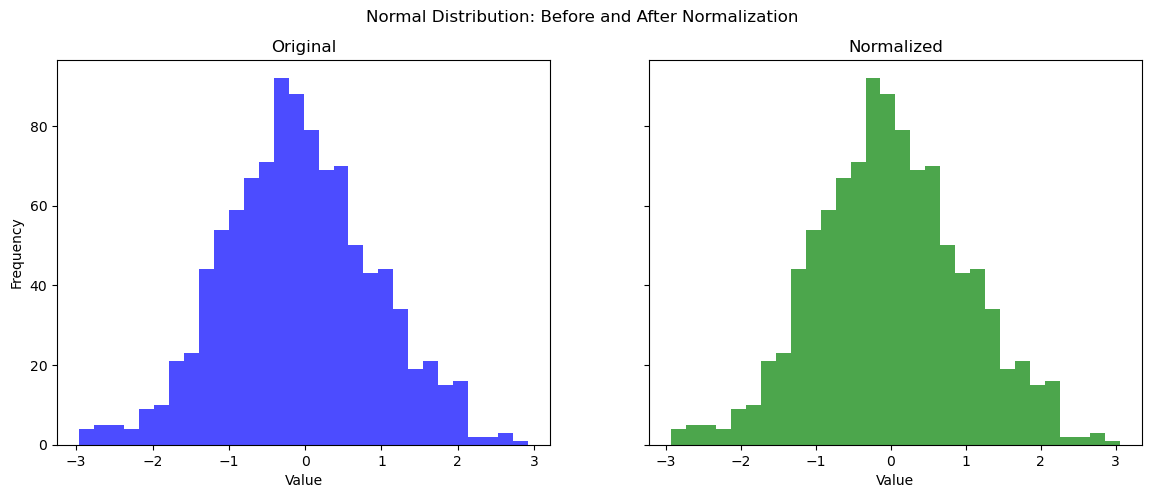

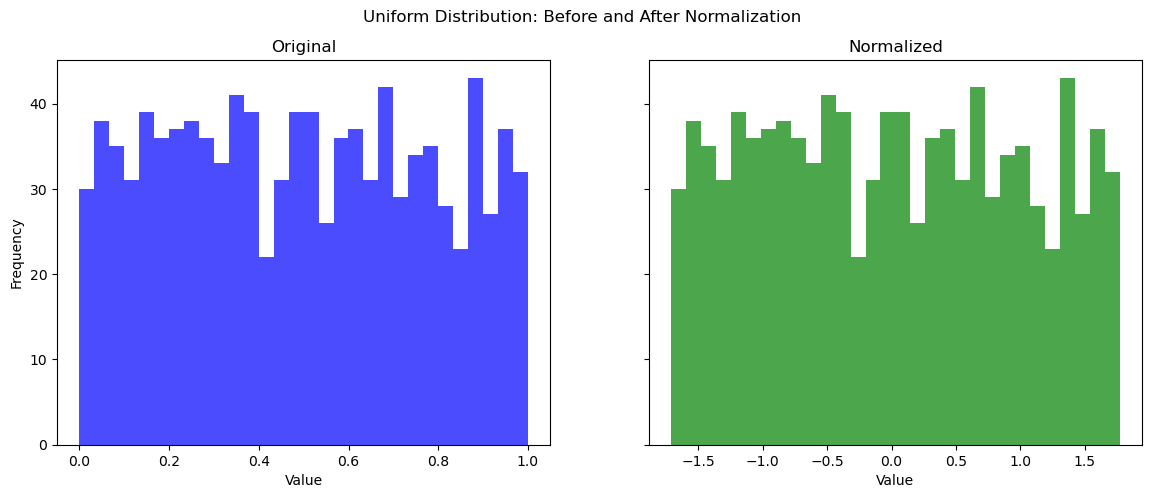

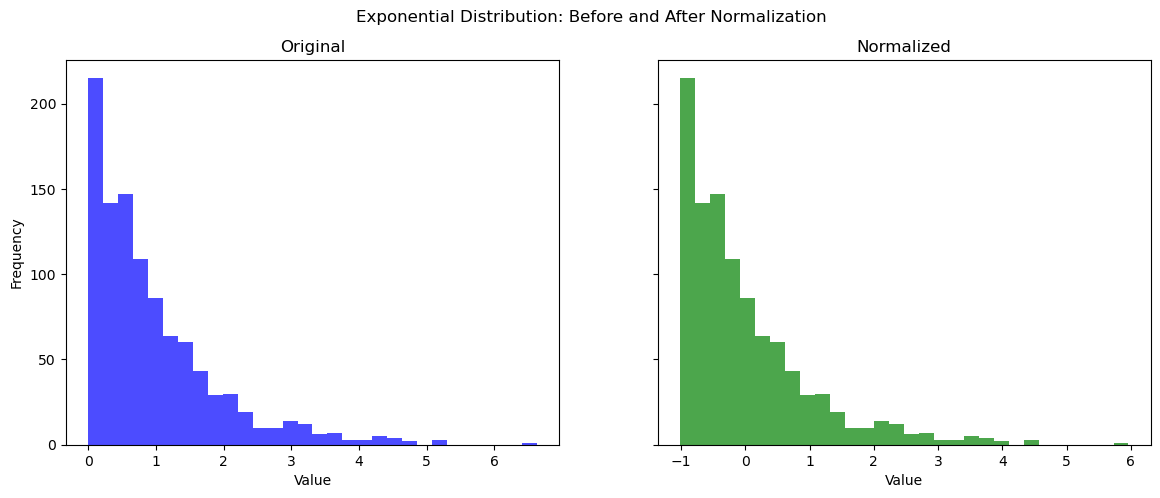

In [182]:
# Function to plot histograms for original and normalized vectors
def plot_histograms(original_vectors, normalized_vectors, distribution):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    fig.suptitle(f'{distribution.capitalize()} Distribution: Before and After Normalization')

    # Original Vector Histogram
    axes[0].hist(original_vectors[distribution][0], bins=30, alpha=0.7, color='blue')
    axes[0].set_title('Original')
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Frequency')

    # Normalized Vector Histogram
    axes[1].hist(normalized_vectors[distribution][0], bins=30, alpha=0.7, color='green')
    axes[1].set_title('Normalized')
    axes[1].set_xlabel('Value')

    plt.show()

# Plot for each distribution
for distribution in ["normal", "uniform", "exponential"]:
    plot_histograms(random_vectors, normalized_vectors, distribution)


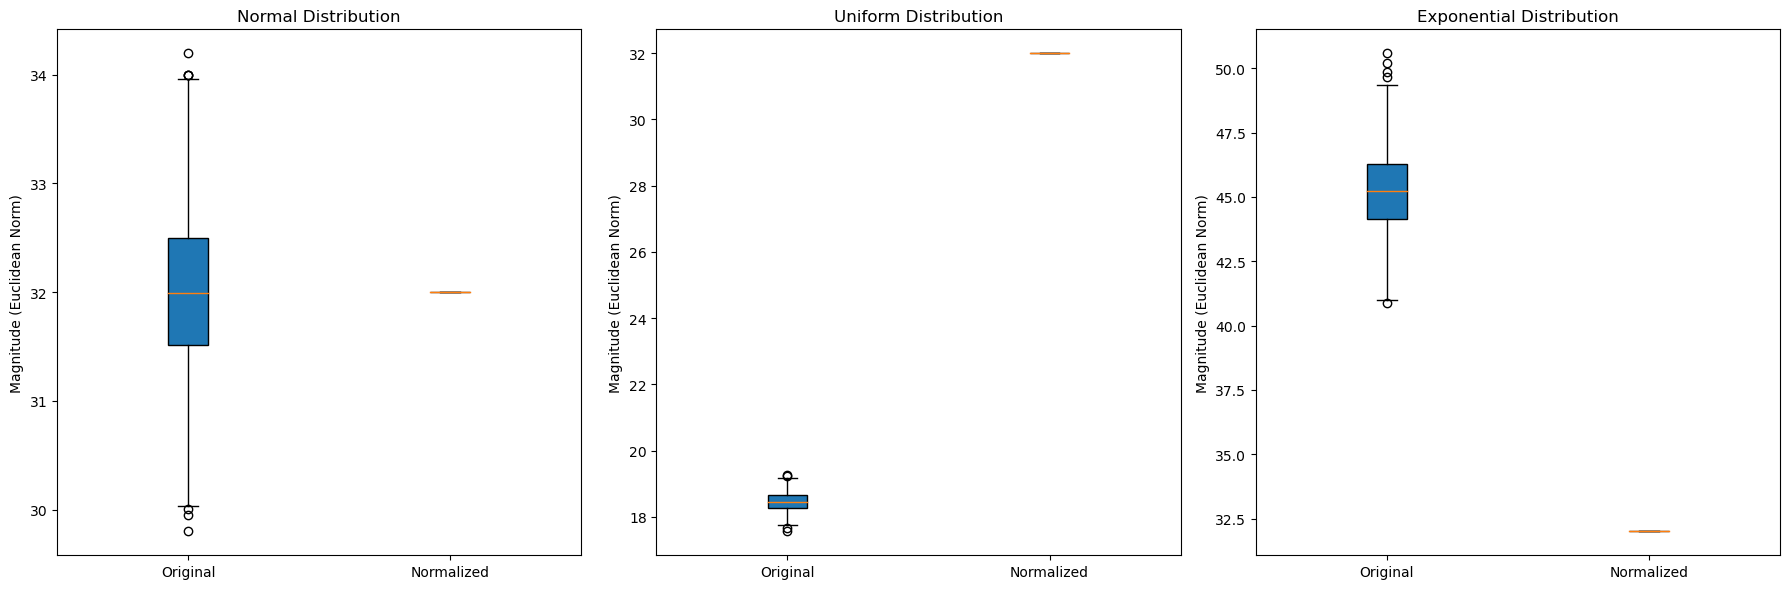

In [183]:
# Function to calculate Euclidean norms for vectors
def calculate_norms(vectors):
    norms = {}
    for key, vecs in vectors.items():
        norms[key] = np.linalg.norm(vecs, axis=1)  # Euclidean norm (L2 norm) of each vector
    return norms

# Calculate norms for original and normalized vectors
original_norms = calculate_norms(random_vectors)
normalized_norms = calculate_norms(normalized_vectors)

# Plotting the magnitudes using box plots
def plot_magnitude_comparison(original_norms, normalized_norms):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    distributions = ['normal', 'uniform', 'exponential']

    for i, distribution in enumerate(distributions):
        # Combine original and normalized norms for plotting
        data = [original_norms[distribution], normalized_norms[distribution]]
        axes[i].boxplot(data, patch_artist=True, labels=['Original', 'Normalized'])
        axes[i].set_title(f'{distribution.capitalize()} Distribution')
        axes[i].set_ylabel('Magnitude (Euclidean Norm)')

    plt.tight_layout()
    plt.show()

plot_magnitude_comparison(original_norms, normalized_norms)


# creating a hierarchy for tokens to impose on the model

In [185]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
print(chars, v)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 65


In [186]:
non_alphabetical = ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?']
# 3 disjoint branches within
endofsentence = ['!','.','?']
mid_sentence = [' ', '$', '&', "'", ',', '-', '3', ':', ';']
other_non_alphabetical = ['\n']
# notice how there are other ways to organize these. here we are imposing our graph structure onto the model, which will be sub-optimal

###### FUNDAMENTAL SCHISM IS BW ALPHABETICAL & NON-ALPHABETICAL

uppercase = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
lowercase = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
vowels = ['A', 'a', 'E', 'e', 'I', 'i', 'O', 'o', 'U', 'u', 'Y', 'y']
consonants = ['B', 'b', 'C', 'c', 'D', 'd', 'F', 'f', 'G', 'g', 'H', 'h', 'J', 'j', 'K', 'k', 'L', 'l', 'M', 'm', 'N', 'n', 'P', 'p', 'Q', 'q', 'R', 'r', 'S', 's', 'T', 't', 'V', 'v', 'W', 'w', 'X', 'x', 'Y', 'y', 'Z', 'z']
uppercase_vowels = ['A', 'E', 'I', 'O', 'U', 'Y']
lowercase_vowels = ['a', 'e', 'i', 'o', 'u', 'y']
uppercase_consonants = ['B', 'C', 'D', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y', 'Z']
lowercase_consonants = ['b', 'c', 'd', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'v', 'w', 'x', 'y', 'z']

# allowing the model to show us its own token hierarchy